In [1]:
import numpy as np
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
### This part just makes it easier to do live updates from the sheet
### This fetches data from the google sheet and writes to the 'EnergyDistributionData.csv'
### However I do not want to put my service key on github, so if you want to run this just ask for the service key
### NOTE for tutors - this section is not necessary, this git repo will contain the data - just run the next cell
scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
#Name of our Service Account Key
google_key_file = 'service_key.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)
spreadsheet_key = '11yF4VFlMYCyfHdulolGM9P_yIwRX9icS-Zv27uayVKY'
sheet_name = 'data_export_exp3'
sheet_name_positive = 'data_export_exp3_set_2'

#negative voltage Values
#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(sheet_name)
values = sheet.get_all_values()
#Pulling the data and transform it to the data frame
df = pd.DataFrame(values[1:], columns = values[0])
# df[['v_b', 'i_b','v_g','i_g','v_y','i_y']] = df[['v_b', 'i_b','v_g','i_g','v_y','i_y']].astype(float)
# df.dtypes
for column in df.columns:
    df[column]= df[column].astype('float64') 
df.to_csv('EnergyDistributionData.csv',index=False)

#postive voltage 
#Opening the worksheet by using Worksheet ID
workbook_positive = gc.open_by_key(spreadsheet_key)
#Selecting which sheet to pulling the data
sheet_positive = workbook.worksheet(sheet_name_positive)
values_positive = sheet_positive.get_all_values()
#Pulling the data and transform it to the data frame
df_positive = pd.DataFrame(values_positive[1:], columns = values_positive[0])
# df[['v_b', 'i_b','v_g','i_g','v_y','i_y']] = df[['v_b', 'i_b','v_g','i_g','v_y','i_y']].astype(float)
# df.dtypes
for column in df_positive.columns:
    df_positive[column]= df_positive[column].replace('',np.nan).astype('float64')
df_positive.to_csv('EnergyDistributionDataPositive.csv',index=False)

In [3]:
#Reading the data
df = pd.read_csv('EnergyDistributionData.csv')
df_positive = pd.read_csv('EnergyDistributionDataPositive.csv')

In [ ]:
#used to generate voltage distribution between i = 0 and i = max
dist = np.linspace(0,3.5,20)
for x in dist: print(round(x,3))

## Initial Data Exploration
Here initially we explore what our data looks like for:
- Our 5 colours of LED
- Only a negative voltage (meaning a retarding potential)
- Using the nA reading for the photocurrent

<Figure size 432x288 with 0 Axes>

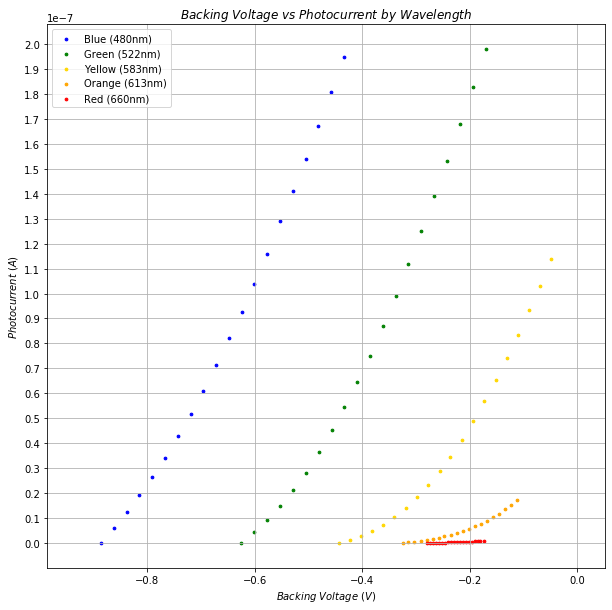

In [253]:
#initial plot of data
plt.clf()
plt.figure(figsize=(10,10))
plt.scatter(df.v_b, df.i_b,color='blue', label="Blue (480nm)", marker='.', s=30)
# plt.scatter(df.v_b, df.i_predicted_b,color='black', label="Blue (480nm)", marker='x', s=20)
plt.scatter(df.v_g,df.i_g, color='green',label="Green (522nm)",marker='.', s=30)
plt.scatter(df.v_y,df.i_y,color='gold',label="Yellow (583nm)",marker='.', s=30)
plt.scatter(df.v_o,df.i_o,color='orange',label="Orange (613nm)",marker='.', s=30)
plt.scatter(df.v_r,df.i_r,color='red',label="Red (660nm)",marker='.', s=30)
plt.title(r'$Backing \ Voltage \ vs \ Photocurrent \ by \ Wavelength$')
plt.xlabel(r'$Backing \ Voltage \ (V)$')
plt.ylabel(r'$Photocurrent \ (A)$')
plt.legend(loc='upper left')
# plt.show()
axes = plt.gca()
axes.set_ylim(-1e-8,max(df.i_g)+ 1e-8)
axes.set_xlim(min(df.v_b)-0.1,max(df.v_y)+0.1)
plt.yticks(np.arange(0,210e-9,10e-9))
plt.grid()
plt.show()

In [ ]:
# linear fit
from scipy.stats import linregress
# blue linear fit (x, y)
regress_b = linregress(df.v_b,df.i_b)
regress_fn_b = lambda x: regress_b.slope*x + regress_b.intercept
# green
regress_g = linregress(df.v_g,df.i_g)
regress_fn_g = lambda x: regress_g.slope*x + regress_g.intercept
# yellow
regress_y = linregress(df.v_y,df.i_y)
regress_fn_y = lambda x: regress_y.slope*x + regress_y.intercept
# orange
regress_o = linregress(df.v_o,df.i_o)
regress_fn_o = lambda x: regress_o.slope*x + regress_o.intercept
# red
regress_r = linregress(df.v_r,df.i_r)
regress_fn_r = lambda x: regress_r.slope*x + regress_r.intercept

v_all = np.concatenate((df.v_b,df.v_g,df.v_y,df.v_o,df.v_r), axis=0)
i_all = np.concatenate((df.i_b,df.i_g,df.i_y,df.i_o,df.i_r), axis=0)
regress_all = linregress(v_all, i_all)
regress_all_fn = lambda x: regress_all.slope*x + regress_all.intercept

## Linear Regressions
Here we run linear regressions across our photocurrents at different voltages (See Results Pt I) 

In [ ]:
plt.clf()
plt.figure(figsize=(14,8))
#blue
plt.scatter(df.v_b, df.i_b,color='blue', label="Blue (480nm)", marker='.', s=20)
label_blue = r"$I_{b} = $"+"{:.2e}".format(regress_b.slope) + "$\cdot V_b + $" +"{:.2e}".format(regress_b.intercept) + ", $r^2=$" + str(round(regress_b.rvalue**2,2))
plt.plot(df.v_b, regress_fn_b(df.v_b), 'b--', label=label_blue)

#green
plt.scatter(df.v_g,df.i_g, color='green',label="Green (522nm)",marker='.', s=20)
label_green = r"$I_{g} = $"+"{:.2e}".format(regress_g.slope) + "$\cdot V_g + $" +"{:.2e}".format(regress_g.intercept)+ ", $r^2=$" + str(round(regress_g.rvalue**2,2))
plt.plot(df.v_g, regress_fn_g(df.v_g), 'g--', label=label_green)

#yellow
plt.scatter(df.v_y,df.i_y,color='gold',label="Yellow (583nm)",marker='.', s=20)
label_yellow = r"$I_{y} = $"+"{:.2e}".format(regress_y.slope) + "$\cdot V_y + $" +"{:.2e}".format(regress_y.intercept)+ ", $r^2=$" + str(round(regress_y.rvalue**2,2))
plt.plot(df.v_y, regress_fn_y(df.v_y), 'y--', label=label_yellow)

#orange
plt.scatter(df.v_o,df.i_o,color='orange',label="Orange (613nm)",marker='.', s=20)
label_orange = r"$I_{o} = $"+"{:.2e}".format(regress_o.slope) + "$\cdot V_o + $" +"{:.2e}".format(regress_o.intercept)+ ", $r^2=$" + str(round(regress_o.rvalue**2,2))
plt.plot(df.v_o, regress_fn_o(df.v_o), '--',color='orange', label=label_orange)

#red
plt.scatter(df.v_r,df.i_r,color='red',label="Red (660nm)",marker='.', s=20)
label_red = r"$I_{r} = $"+"{:.2e}".format(regress_r.slope) + "$\cdot V_r + $" +"{:.2e}".format(regress_r.intercept)+ ", $r^2=$" + str(round(regress_r.rvalue**2,2))
plt.plot(df.v_r, regress_fn_r(df.v_r), 'r--', label=label_red)

#all
label_all = r"$I_{a} = $"+"{:.2e}".format(regress_all.slope) + "$\cdot V_a + $" +"{:.2e}".format(regress_all.intercept)+ ", $r^2=$" + str(round(regress_all.rvalue**2,2))
plt.plot(v_all, regress_all_fn(v_all), 'black', label=label_all)


plt.title(r'$Backing \ Voltage \ vs \ Photocurrent \ by \ Wavelength$')
plt.xlabel(r'$Backing \ Voltage \ (V)$')
plt.ylabel(r'$Photocurrent \ (A)$')
plt.legend(loc='upper left')
axes = plt.gca()
axes.set_ylim(-1e-8,max(df.i_g)+ 1e-8)
axes.set_xlim(min(df.v_b)-0.1,max(df.v_y)+0.1)
plt.yticks(np.arange(0,210e-9,10e-9))
plt.grid()
plt.show()

## Analysis of Linear Regressions

In [ ]:
from IPython.display import HTML, display
import tabulate
regression_data = [regress_b,regress_g,regress_y,regress_o,regress_r]
colours = ['Blue','Green','Yellow','Orange','Red']
table = [['Colour','Slope','Intercept','R-Value','P-value','Standard-Error']]
for i,item in enumerate(regression_data):
    item_data = [colours[i],"{:.2e}".format(item.slope),"{:.2e}".format(item.intercept),item.rvalue,"{:.2e}".format(item.pvalue),"{:.2e}".format(item.stderr)]
    table.append(item_data)
display(HTML(tabulate.tabulate(table, tablefmt='html')))   
pd.DataFrame(table).to_csv('LinearResssionOutput.csv',index=False)

## Considering the theoretical vs predicted stopping voltages

In [ ]:
theoretical_stopping = []
theoretical_uncertainty = []
oberserved_stopping = [-0.892,-0.609,-0.448,-0.333,-0.254]
oberserved_uncertainty = [0.002,0.001,0.002,0.004,0.018]

for i,item in enumerate(regression_data):
    theoretical_stopping.append(-item.intercept/item.slope)
    theoretical_uncertainty.append(item.stderr)
    
x = np.arange(len(theoretical_stopping))
width = 0.35
fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, oberserved_stopping, width, label='Oberserved Stopping Voltage', yerr=oberserved_uncertainty)
bar2 = ax.bar(x + width/2, theoretical_stopping, width, label='Linear Prediction Stopping Voltage', yerr=theoretical_uncertainty)
plt.legend()
plt.title('Oberserved vs Linearly Predicted Stopping Voltage')
plt.ylabel('Voltage')
ax.set_xticks(x)
ax.set_xticklabels(colours)
fig.set_figheight(7)
fig.set_figwidth(10)
fig.tight_layout()
# plt.gid()
plt.grid(which='both')
plt.show()

## Plotting photocurrent vs backing voltage where the backing voltage is positive (accelerating electric field)

In [ ]:
plt.clf()
plt.figure(figsize=(10,10))
plt.scatter(df_positive.v_b, df_positive.i_b,color='blue', label="Blue (480nm)", marker='.', s=40)
plt.scatter(df_positive.v_g,df_positive.i_g, color='green',label="Green (522nm)",marker='.', s=40)
plt.scatter(df_positive.v_y,df_positive.i_y,color='gold',label="Yellow (583nm)",marker='.', s=40)
plt.scatter(df_positive.v_o,df_positive.i_o,color='orange',label="Orange (613nm)",marker='.', s=40)
plt.scatter(df_positive.v_r,df_positive.i_r,color='red',label="Red (660nm)",marker='.', s=40)
plt.title(r'$Backing \ Voltage \ vs \ Photocurrent \ by \ Wavelength$')
plt.xlabel(r'$Backing \ Voltage \ (V)$')
plt.ylabel(r'$Photocurrent \ (A)$')
plt.legend(loc='upper left')
# plt.show()
axes = plt.gca()
axes.set_ylim(-0.1e-5,max(df_positive.i_b)+ 1e-8)
axes.set_xlim(-0.1,max(df_positive.v_y)+0.1)
# plt.yticks(np.arange(0,210e-9,10e-9))
plt.grid()
plt.show()

# Combining data from the negative and positive backing voltages to obtain a the final distribution we will use for modeling

In [254]:
v_y_full = df.v_y.append(df_positive.v_y)
i_y_full = df.i_y.append(df_positive.i_y)
v_g_full = df.v_g.append(df_positive.v_g)
i_g_full = df.i_g.append(df_positive.i_g)
v_o_full = df.v_o.append(df_positive.v_o)
i_o_full = df.i_o.append(df_positive.i_o)

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(-v_y_full, i_y_full,color='gold', label="Yellow (583nm)", marker='.', s=40)
plt.scatter(-v_g_full, i_g_full,color='green', label="Green (522nm)", marker='.', s=40)
plt.scatter(-v_o_full, i_o_full,color='orange', label="Orange (613nm)", marker='.', s=40)

plt.title(r'$Photocurrent \ by \ Wavelength$')
plt.xlabel(r'$Reverse \ Bias \ (V)$')
plt.ylabel(r'$Photocurrent \ (A)$')
plt.legend(loc='center left')
# plt.show()
axes = plt.gca()
axes.set_ylim(min(i_g_full)-1e-7,max(i_g_full)+1e-7)
axes.set_xlim(min(-v_g_full)-0.1,max(-v_g_full)+0.1)
# plt.yticks(np.arange(0,210e-9,10e-9))
plt.grid()
plt.show()

## Creating a polynomial fit for our full distribution

In [ ]:
# fit a model for each of the curves using polyfit
import numpy.polynomial.polynomial as poly

#polynomial fits
coeffs_g = poly.polyfit(-v_g_full, i_g_full, 9)
poly_fn_g = poly.Polynomial(coeffs_g)
coeffs_y = poly.polyfit(-v_y_full, i_y_full, 9)
poly_fn_y = poly.Polynomial(coeffs_y)
coeffs_o = poly.polyfit(-v_o_full, i_o_full, 9)
poly_fn_o = poly.Polynomial(coeffs_o)

plt.figure(figsize=(7,5))
plt.scatter(-v_g_full, i_g_full,color='green', label="Green (522nm)", marker='.', s=40)
plt.plot(-v_g_full, poly_fn_g(-v_g_full),'g--', label='Green - Model Fit')
plt.scatter(-v_o_full, i_o_full,color='orange', label="Orange (613nm)", marker='.', s=40)
plt.plot(-v_o_full, poly_fn_o(-v_o_full),'--',color='orange', label='Orange - Model Fit')
plt.scatter(-v_y_full, i_y_full,color='gold', label="Yellow (583nm)", marker='.', s=40)
plt.plot(-v_y_full, poly_fn_y(-v_y_full),'--',color='gold', label='Yellow - Model Fit')

plt.title(r'$Photocurrent \ by \ Wavelength$')
plt.xlabel(r'$Reverse \ Bias \ (V)$')
plt.ylabel(r'$Photocurrent \ (A)$')
plt.legend(loc='center left')
# plt.show()
axes = plt.gca()
axes.set_ylim(min(i_g_full)-1e-7,max(i_g_full)+1e-7)
axes.set_xlim(min(-v_g_full)-0.1,max(-v_g_full)+0.1)
# plt.yticks(np.arange(0,210e-9,10e-9))
plt.grid()
plt.show()

## Plotting Residuals

In [ ]:
plt.figure(figsize=(6,2))

plt.plot(-v_g_full,i_g_full- poly_fn_g(-v_g_full), 'g', label='Green')
plt.plot(-v_y_full,i_y_full- poly_fn_y(-v_y_full), c='gold', label='Yellow')
plt.plot(-v_o_full,i_o_full- poly_fn_o(-v_o_full), c='orange', label='Orange')

plt.title(r'$Residuals$')
plt.xlabel(r'$Reverse \ Bias \ (V)$')
plt.ylabel(r'$Residual (\hatY)-Y \ (A)$')
plt.legend(loc='lower left')
# plt.show()
axes = plt.gca()
axes.set_ylim(min(i_g_full- poly_fn_g(-v_g_full)),max(i_g_full- poly_fn_g(-v_g_full)))
axes.set_xlim(min(-v_g_full)-0.1,max(-v_g_full)+0.1)
# plt.yticks(np.arange(0,210e-9,10e-9))
plt.grid()
plt.show()

## Final Energy Distribution as mentioned in Results part II

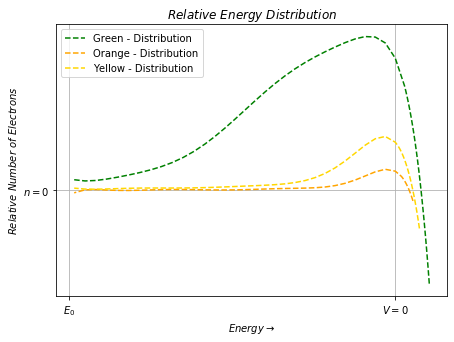

In [248]:
#polynomial derivatives - representing energy distribution
coeffs_g_2 = poly.polyder(coeffs_g, m=1)
poly_fn_g_2 = poly.Polynomial(-coeffs_g_2)
coeffs_y_2 = poly.polyder(coeffs_y, m=1)
poly_fn_y_2 = poly.Polynomial(-coeffs_y_2)
coeffs_o_2 = poly.polyder(coeffs_o, m=1)
poly_fn_o_2 = poly.Polynomial(-coeffs_o_2)

plt.figure(figsize=(7,5))
plt.plot(-v_g_full, poly_fn_g_2(-v_g_full),'g--', label='Green - Distribution')
plt.plot(-v_o_full, poly_fn_o_2(-v_o_full),'--',color='orange', label='Orange - Distribution')
plt.plot(-v_y_full, poly_fn_y_2(-v_y_full),'--',color='gold', label='Yellow - Distribution')

plt.title(r'$Relative \ Energy \ Distribution$')
plt.xlabel(r'$Energy \rightarrow$')
plt.ylabel(r'$Relative \ Number \ of \ Electrons $')
plt.legend(loc='upper left')
plt.yticks([0],[r'$n=0$'])
plt.xticks([-6,0],[r'$E_0$',r'$V = 0$'])
# plt.show()
# axes = plt.gca()
# axes.set_ylim(min(i_g_full)-1e-7,max(i_g_full)+1e-7)
# axes.set_xlim(min(-v_g_full)-0.1,max(-v_g_full)+0.1)
# plt.yticks(np.arange(0,210e-9,10e-9))
plt.grid()
plt.show()